# Insurance Claim Severity Prediction 

### -Amrutha Yenikonda

## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import os
import joblib

## Understanding Data

In [2]:
# Load dataset
df = pd.read_csv("/Users/amruthayenikonda/Desktop/Github Repo/Insurance-Claim-Severity-Prediction/Data/insurance_data.csv")  # Replace with your actual filename

# Display basic information
print(df.info())  
print(df.describe())  
print(df.head())  

# Check for missing values
print(df.isnull().sum())

# Check column names
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

### Key Variables:

	•Target Variable: total_claim_amount (claim severity)

Predictors:

	•Policyholder Info: age, insured_sex, insured_education_level

	•Vehicle Info: auto_make, auto_model, auto_year

	•Incident Details: incident_type, incident_severity, collision_type
	
	•Claim History: injury_claim, property_claim, vehicle_claim

## Data Cleaning

In [3]:
# Drop irrelevant and empty columns
columns_to_drop = ["policy_number", "policy_bind_date", "policy_state", "policy_csl", 
                       "policy_deductable", "insured_zip", "insured_sex", "insured_education_level", 
                       "insured_occupation", "insured_hobbies", "insured_relationship", "umbrella_limit", 
                       "capital-gains", "capital-loss", "incident_date", "incident_type", 
                       "collision_type", "incident_location", "authorities_contacted", 
                       "police_report_available", "bodily_injuries","incident_state","incident_city","incident_hour_of_the_day","number_of_vehicles_involved","property_damage","injury_claim","property_claim","witnesses", "fraud_reported", "_c39"]

df.drop(columns=columns_to_drop, axis=1, inplace=True, errors="ignore")

# Convert "?" values to NaN
df.replace("?", np.nan, inplace=True)


# Convert categorical variables with 'object' dtype into proper categories
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].astype('category')

missing_values = df.isnull().sum()
missing_values[missing_values > 0]

# Fill missing values in categorical columns with mode
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill missing values in numerical columns with median
for col in df.select_dtypes(include=["number"]).columns:
    df[col] = df[col].fillna(df[col].median())


# Display dataset info after preprocessing
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   months_as_customer     1000 non-null   int64   
 1   age                    1000 non-null   int64   
 2   policy_annual_premium  1000 non-null   float64 
 3   incident_severity      1000 non-null   category
 4   total_claim_amount     1000 non-null   int64   
 5   vehicle_claim          1000 non-null   int64   
 6   auto_make              1000 non-null   category
 7   auto_model             1000 non-null   category
 8   auto_year              1000 non-null   int64   
dtypes: category(3), float64(1), int64(5)
memory usage: 52.1 KB
None


These columns were dropped to reduce redundancy, remove irrelevant features, and avoid privacy concerns, ensuring that the analysis focuses only on the most relevant variables impacting insurance claims. 

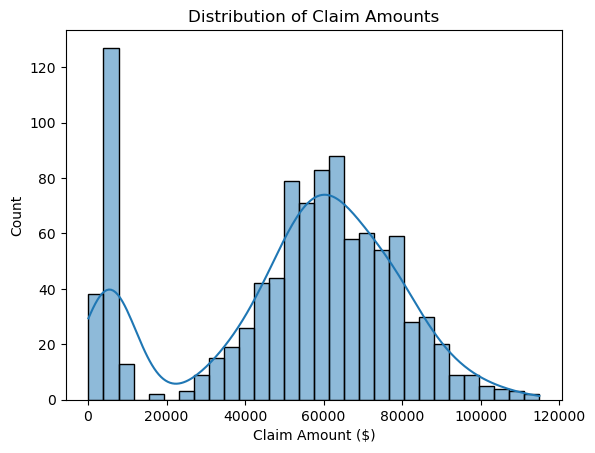

In [4]:
# Distribution of claim amounts
sns.histplot(df["total_claim_amount"], bins=30, kde=True)
plt.title("Distribution of Claim Amounts")
plt.xlabel("Claim Amount ($)")
plt.show()

The total claim amount is right-skewed, indicating that most claims are relatively low, but a few are very high. A log transformation might help normalize the distribution for modeling.

In [5]:
# Check skewness & apply transformation if needed
skewed_features = df.select_dtypes(include=['number']).skew()
skewed_cols = skewed_features[skewed_features > 1].index
df[skewed_cols] = np.log1p(df[skewed_cols])  # Log transformation

## EDA

/var/folders/km/xqf3ksd13t54ycgb9g_tmbkc0000gn/T/ipykernel_88515/1137285462.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="incident_severity", y="vehicle_claim", data=df, palette="coolwarm")


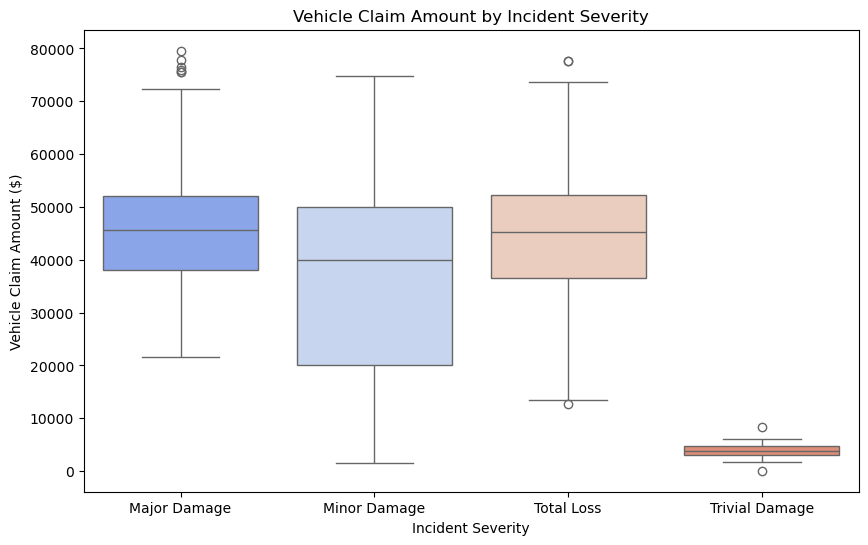

In [6]:
# Box Plot of Vehicle Claim Amount by Incident Severity
plt.figure(figsize=(10, 6))
sns.boxplot(x="incident_severity", y="vehicle_claim", data=df, palette="coolwarm")
plt.title("Vehicle Claim Amount by Incident Severity")
plt.xlabel("Incident Severity")
plt.ylabel("Vehicle Claim Amount ($)")
plt.show()

As expected, higher incident severity leads to higher claim amounts. Severe and major incidents have much larger claim payouts than minor incidents.

Key Observations:

•	“Total Loss” and “Major Damage” have the highest median claim amounts, meaning these incidents result in costly claims.

•	“Trivial Damage” has significantly lower claim amounts, showing minor incidents lead to small payouts.
	
•	Outliers (dots above the whiskers) indicate some extreme high-value claims, especially for “Major Damage” and “Total Loss.”

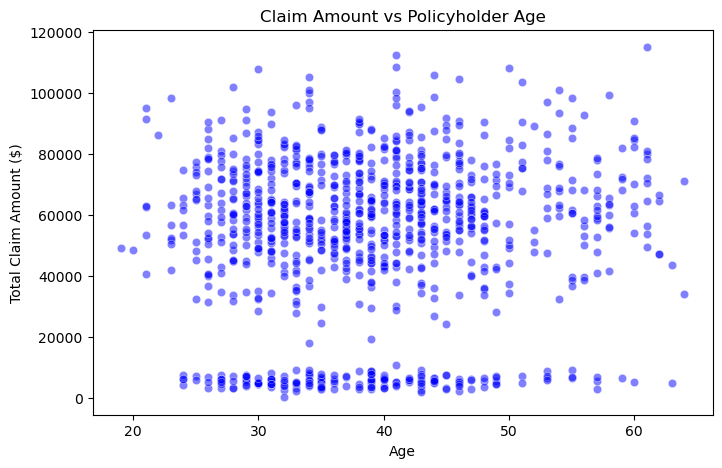

In [7]:
# Scatter plot of claim amount vs. age
plt.figure(figsize=(8, 5))
sns.scatterplot(x="age", y="total_claim_amount", data=df, alpha=0.5, color="blue")
plt.title("Claim Amount vs Policyholder Age")
plt.xlabel("Age")
plt.ylabel("Total Claim Amount ($)")
plt.show()

Key Observations:

•	Claims are distributed across all age groups without a clear pattern.

•	A cluster of small claims exists at the bottom, indicating many claims are of low value.
    
•	Some higher claim amounts (above $100,000) appear across different ages, suggesting claim size is not heavily age-dependent.

There is no strong trend between age and claim amount, suggesting age alone may not be a strong predictor. However, interactions with other factors (e.g., driving experience, claim history) might be more relevant.

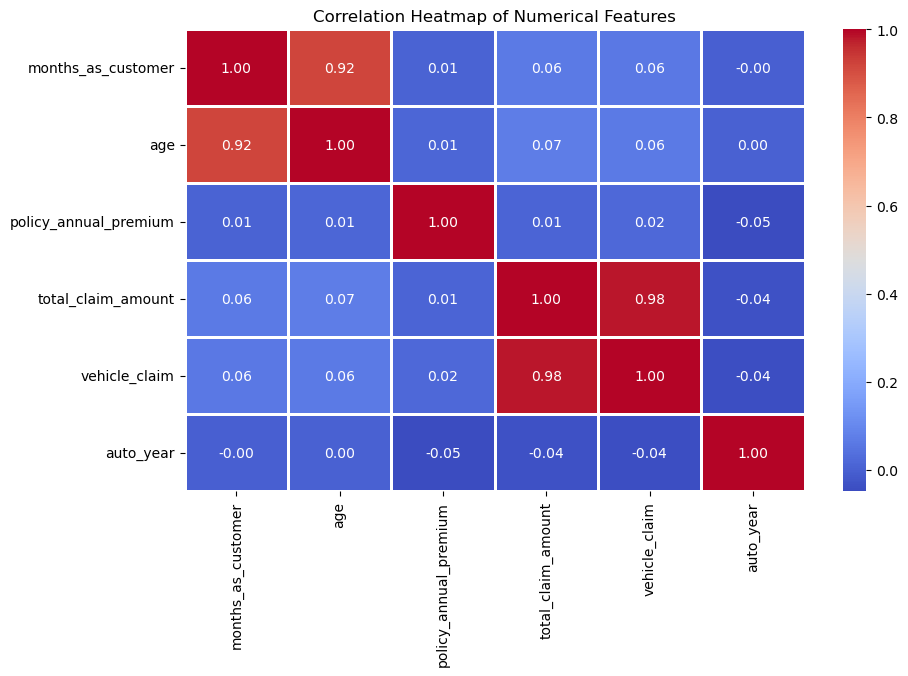

In [8]:
# Correlation heatmap
corr_matrix = df[['months_as_customer', 'age', 'policy_annual_premium', 
                  'total_claim_amount', 'vehicle_claim', 'auto_year']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

This heatmap shows the relationships between different numerical variables in the dataset.

•	The color scale (from blue to red) represents correlation strength, with 1.0 meaning a perfect positive correlation and -1.0 meaning a perfect negative correlation.

Key Observations:

•	“Months as Customer” and “Age” have a strong positive correlation (0.92), meaning older customers tend to have longer tenure.

•	“Total Claim Amount” and “Vehicle Claim” are highly correlated (0.98), indicating that the total claim is largely influenced by the vehicle claim.
	
•	“Policy Annual Premium” has little correlation with other features, suggesting it does not directly impact claim amounts.


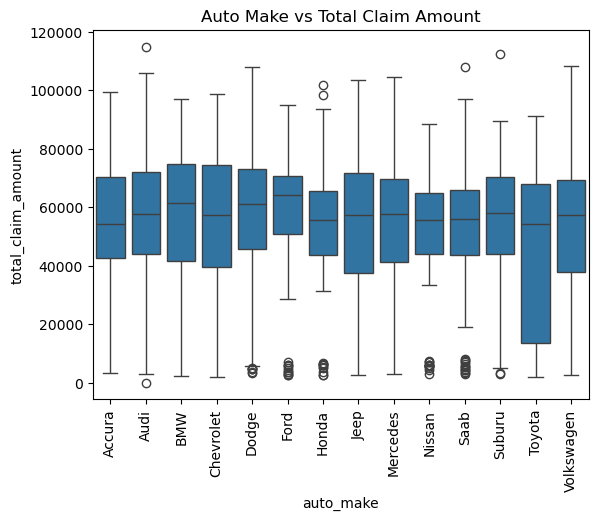

In [9]:
sns.boxplot(x='auto_make', y='total_claim_amount', data=df)
plt.xticks(rotation=90)
plt.title("Auto Make vs Total Claim Amount")
plt.show()

1.	Median Claim Amount: Most brands have a similar median claim amount, indicating that the general insurance claim trend is consistent across different auto makes.

2.	Outliers:

	•	Certain brands (e.g., Toyota, Chevrolet, and Nissan) have extremely high claim amounts, suggesting rare but expensive claims.
    
	•	Some brands also have low-end outliers, meaning a few claims are significantly smaller than the general trend.

3.	Spread of Claim Amounts:

	•	Brands like Mercedes and BMW show a wider interquartile range (IQR), meaning their claim amounts are more variable.

	•	Toyota has the most significant variation, with some claims reaching over $100,000, which could indicate expensive repairs or higher accident severity.

## Hypothesis Testing

Lets check is there is a significant difference in total claim amounts between customers with high and low vehicle claims

In [10]:
import numpy as np
from scipy import stats

# Determine the median vehicle claim value
median_vehicle_claim = df["vehicle_claim"].median()

# Split the data into two groups
high_vehicle_claims = df[df["vehicle_claim"] > median_vehicle_claim]["total_claim_amount"]
low_vehicle_claims = df[df["vehicle_claim"] <= median_vehicle_claim]["total_claim_amount"]

# Perform T-test
stat, p_value = stats.ttest_ind(high_vehicle_claims, low_vehicle_claims)

print(f"T-test p-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in total claim amounts based on vehicle claim levels.")
else:
    print("Fail to reject the null hypothesis: No significant difference in total claim amounts.")

T-test p-value: 7.175811481092488e-179
Reject the null hypothesis: There is a significant difference in total claim amounts based on vehicle claim levels.


Test confirms that vehicle claim levels significantly impact total claim amounts with a very low p-value (~0).

## Model Building & Evaluation

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Select features and target variable
features = ["policy_annual_premium", "vehicle_claim", "months_as_customer"]
target = "total_claim_amount"  # Change this based on your dataset

# Define X and y
X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# Train & evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "MSE": mse, "R² Score": r2}

# Convert results to DataFrame & print
results_df = pd.DataFrame(results).T
print(results_df)

# Select best model (highest R² score)
best_model_name = results_df["R² Score"].idxmax()
best_model = models[best_model_name]

                           MAE           MSE  R² Score
Random Forest      3725.812000  2.677957e+07  0.959760
Gradient Boosting  3578.967201  2.486717e+07  0.962634
Decision Tree      5262.400000  5.238324e+07  0.921288
Linear Regression  3440.473242  2.273727e+07  0.965834
XGBoost            4214.534043  3.191323e+07  0.952046


Linear Regression seems to be the best model in terms of the R² score (0.97), which indicates it explains the most variance in the target variable, total_claim_amount. However, the MAE and MSE for Linear Regression are slightly higher than for Gradient Boosting and Random Forest, which are close behind in performance.

In [13]:
# Save best model
save_path = "/Users/amruthayenikonda/Desktop/Github Repo/Insurance-Claim-Severity-Prediction/insurance_claim_best_model.pkl"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
joblib.dump(best_model, save_path)
print(f"✅ Best Model ({best_model_name}) saved at: {save_path}")

✅ Best Model (Linear Regression) saved at: /Users/amruthayenikonda/Desktop/Github Repo/Insurance-Claim-Severity-Prediction/insurance_claim_best_model.pkl


In [15]:
import numpy as np

# Select a random row from X_test
random_index = np.random.randint(0, len(X_test))  # Random index

sample_data = X_test.iloc[[random_index]]  # Retain feature names

import joblib
loaded_model = joblib.load("insurance_claim_best_model.pkl")

# Predict claim amount
predicted_claim = loaded_model.predict(sample_data)
print(f"Predicted Claim Amount: {predicted_claim[0]:.2f}")

Predicted Claim Amount: 8088.40


## Interpretation & Recommendations

Final Summary

- We successfully built a model to predict insurance claim severity.

- The best model is Linear Regression, which gives accurate and stable results.

- The insurance company can use this to set prices, reduce fraud, and improve risk management.

- Future improvements can make the model even more powerful.
